<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Pass_Optimalisation_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# STEP 3: Load match file
file_path = '/content/drive/MyDrive/Outswinger FC/Eredivisie Women 2024-2025/Utrecht 1-0 Feyenoord.csv'
df = pd.read_csv(file_path)

# STEP 4: Filter for passes (typeId == 1)
passes = df[df['typeId'] == 1].copy()

# STEP 5: Extract end_x and end_y from qualifier IDs 140 and 141
def extract_qualifier_value(row, target_id):
    for i in range(20):  # Scan up to 20 qualifier columns
        qid_col = f'qualifier/{i}/qualifierId'
        val_col = f'qualifier/{i}/value'
        if qid_col in row and val_col in row:
            if pd.notnull(row[qid_col]) and int(row[qid_col]) == target_id:
                try:
                    return float(row[val_col])
                except:
                    return np.nan
    return np.nan

passes['end_x'] = passes.apply(lambda row: extract_qualifier_value(row, 140), axis=1)
passes['end_y'] = passes.apply(lambda row: extract_qualifier_value(row, 141), axis=1)
passes.dropna(subset=['x', 'y', 'end_x', 'end_y'], inplace=True)

# STEP 6: Select target player
target_player = 'J. Teulings'  # Replace with any valid player name
player_passes = passes[passes['playerName'] == target_player].copy()

# STEP 7: xPass model
def calculate_xpass_advanced(start_x, start_y, end_x, end_y):
    dx = end_x - start_x
    dy = end_y - start_y
    distance = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx)

    # Enhanced logistic regression model
    b0 = 3.0
    b1 = -0.07
    b2 = -1.2
    b3 = -0.015
    b4 = -0.015
    b5 = -0.01

    z = (
        b0 +
        b1 * distance +
        b2 * abs(angle) +
        b3 * abs(52.5 - end_x) +
        b4 * abs(34 - end_y) +
        b5 * (105 - start_x)
    )
    return 1 / (1 + np.exp(-z))

# STEP 8: Threat Gain function
goal_x, goal_y = 105, 34
def calculate_threat_gain(start_x, start_y, end_x, end_y):
    start_dist = np.sqrt((goal_x - start_x)**2 + (goal_y - start_y)**2)
    end_dist = np.sqrt((goal_x - end_x)**2 + (goal_y - end_y)**2)
    return start_dist - end_dist

# STEP 9: Optimal passes from point
def get_top_pass_options_from(x, y, n_options=3, step=5):
    target_x = np.arange(5, 105, step)
    target_y = np.arange(5, 68, step)
    options = []
    for tx in target_x:
        for ty in target_y:
            if np.sqrt((x - tx)**2 + (y - ty)**2) > 50:
                continue
            xpass = calculate_xpass_advanced(x, y, tx, ty)
            threat = calculate_threat_gain(x, y, tx, ty)
            expected_value = xpass * threat
            options.append((tx, ty, expected_value))
    top_options = sorted(options, key=lambda x: x[2], reverse=True)[:n_options]
    return top_options

# STEP 10: Evaluate every pass by the player
all_pass_results = []

for index, row in player_passes.iterrows():
    x, y = row['x'], row['y']
    end_x, end_y = row['end_x'], row['end_y']

    # Actual pass
    actual_xpass = calculate_xpass_advanced(x, y, end_x, end_y)
    actual_threat = calculate_threat_gain(x, y, end_x, end_y)
    actual_ev = actual_xpass * actual_threat

    all_pass_results.append({
        'pass_id': index,
        'type': 'actual',
        'start_x': x,
        'start_y': y,
        'end_x': end_x,
        'end_y': end_y,
        'xPass': actual_xpass,
        'threat_gain': actual_threat,
        'expected_value': actual_ev
    })

    # Optimal options
    top_options = get_top_pass_options_from(x, y, n_options=3)
    for i, (tx, ty, ev) in enumerate(top_options, 1):
        xpass_opt = calculate_xpass_advanced(x, y, tx, ty)
        threat_opt = calculate_threat_gain(x, y, tx, ty)
        all_pass_results.append({
            'pass_id': index,
            'type': f'optimal_{i}',
            'start_x': x,
            'start_y': y,
            'end_x': tx,
            'end_y': ty,
            'xPass': xpass_opt,
            'threat_gain': threat_opt,
            'expected_value': ev
        })

# STEP 11: Save to Excel
all_pass_df = pd.DataFrame(all_pass_results)
filename_safe = target_player.replace(" ", "_").replace(".", "")
output_path = f'/content/drive/MyDrive/Outswinger FC/Pass_Evaluation_{filename_safe}.xlsx'
all_pass_df.to_excel(output_path, index=False)

print(f"✅ All passes by {target_player} saved to:\n{output_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ All passes by J. Teulings saved to:
/content/drive/MyDrive/Outswinger FC/Pass_Evaluation_J_Teulings.xlsx


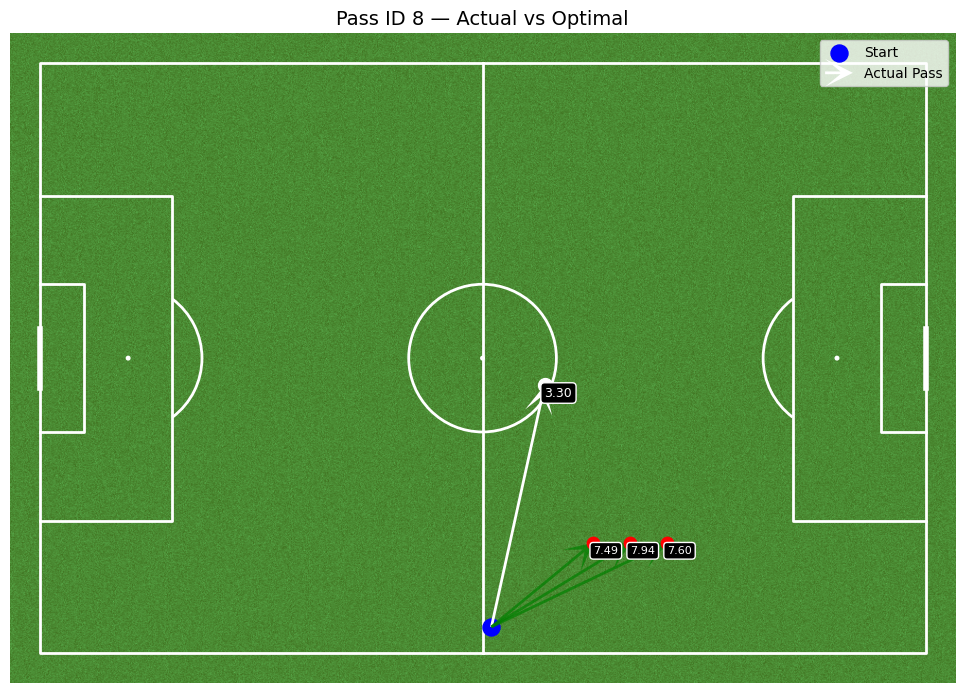

In [18]:
# STEP: Visualize a specific pass by pass_id
visual_pass_id = 8  # Replace with a valid pass_id

selected_pass = all_pass_df[all_pass_df['pass_id'] == visual_pass_id]

if selected_pass.empty:
    print(f"❌ No pass found with ID {visual_pass_id}")
else:
    actual = selected_pass[selected_pass['type'] == 'actual'].iloc[0]
    optimals = selected_pass[selected_pass['type'].str.contains('optimal')].sort_values('type')

    pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
    fig, ax = pitch.draw(figsize=(10, 7))

    pitch.scatter(actual['start_x'], actual['start_y'], ax=ax, color='blue', s=150, label='Start')

    pitch.arrows(actual['start_x'], actual['start_y'], actual['end_x'], actual['end_y'],
                 ax=ax, color='white', width=2, headwidth=10, headlength=10, label='Actual Pass')
    pitch.scatter(actual['end_x'], actual['end_y'], ax=ax, color='white', s=100)
    ax.text(actual['end_x'], actual['end_y'] + 1.5, f"{actual['expected_value']:.2f}",
            color='white', fontsize=9,
            bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.3'))

    for _, opt in optimals.iterrows():
        pitch.arrows(opt['start_x'], opt['start_y'], opt['end_x'], opt['end_y'],
                     ax=ax, color='green', width=2, headwidth=10, headlength=10, alpha=0.7)
        pitch.scatter(opt['end_x'], opt['end_y'], ax=ax, color='red', s=80)
        ax.text(opt['end_x'], opt['end_y'] + 1.5, f"{opt['expected_value']:.2f}",
                color='white', fontsize=8,
                bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.3'))

    plt.title(f"Pass ID {visual_pass_id} — Actual vs Optimal", fontsize=14)
    plt.legend()
    plt.show()


In [20]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

# STEP 3: Load match CSV
file_path = '/content/drive/MyDrive/Outswinger FC/Eredivisie Women 2024-2025/Utrecht 1-0 Feyenoord.csv'
df = pd.read_csv(file_path)

# STEP 4: Filter passes
passes = df[df['typeId'] == 1].copy()

# STEP 5: Extract end_x and end_y from flattened qualifiers
def extract_qualifier_value(row, target_id):
    for i in range(20):
        qid_col = f'qualifier/{i}/qualifierId'
        val_col = f'qualifier/{i}/value'
        if qid_col in row and val_col in row:
            if pd.notnull(row[qid_col]) and int(row[qid_col]) == target_id:
                try:
                    return float(row[val_col])
                except:
                    return np.nan
    return np.nan

passes['end_x'] = passes.apply(lambda row: extract_qualifier_value(row, 140), axis=1)
passes['end_y'] = passes.apply(lambda row: extract_qualifier_value(row, 141), axis=1)
passes.dropna(subset=['x', 'y', 'end_x', 'end_y', 'playerName', 'contestantId'], inplace=True)

# STEP 6: Define xPass model
def calculate_xpass_advanced(start_x, start_y, end_x, end_y):
    dx = end_x - start_x
    dy = end_y - start_y
    distance = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx)

    b0 = 3.0
    b1 = -0.07
    b2 = -1.2
    b3 = -0.015
    b4 = -0.015
    b5 = -0.01

    z = (
        b0 +
        b1 * distance +
        b2 * abs(angle) +
        b3 * abs(52.5 - end_x) +
        b4 * abs(34 - end_y) +
        b5 * (105 - start_x)
    )
    return 1 / (1 + np.exp(-z))

# STEP 7: Threat gain
goal_x, goal_y = 105, 34
def calculate_threat_gain(start_x, start_y, end_x, end_y):
    start_dist = np.sqrt((goal_x - start_x)**2 + (goal_y - start_y)**2)
    end_dist = np.sqrt((goal_x - end_x)**2 + (goal_y - end_y)**2)
    return start_dist - end_dist

# STEP 8: Get top optimal pass options from a location
def get_top_pass_options_from(x, y, n_options=3, step=5):
    target_x = np.arange(5, 105, step)
    target_y = np.arange(5, 68, step)
    options = []
    for tx in target_x:
        for ty in target_y:
            if np.sqrt((x - tx)**2 + (y - ty)**2) > 50:
                continue
            xpass = calculate_xpass_advanced(x, y, tx, ty)
            threat = calculate_threat_gain(x, y, tx, ty)
            expected_value = xpass * threat
            options.append((tx, ty, expected_value))
    top_options = sorted(options, key=lambda x: x[2], reverse=True)[:n_options]
    return top_options

# STEP 9: Compute POI for all players
player_results = []
players = passes['playerName'].dropna().unique()

for player in tqdm(players):
    player_data = passes[passes['playerName'] == player].copy()
    contestant_id = player_data['contestantId'].iloc[0]

    total_ev = 0
    poi_sum = 0
    poi_count = 0

    for idx, row in player_data.iterrows():
        x, y = row['x'], row['y']
        end_x, end_y = row['end_x'], row['end_y']

        ev_actual = calculate_xpass_advanced(x, y, end_x, end_y) * calculate_threat_gain(x, y, end_x, end_y)
        top_opts = get_top_pass_options_from(x, y, n_options=3)
        ev_best = max(opt[2] for opt in top_opts)

        poi = ev_actual / ev_best if ev_best > 0 else 0

        total_ev += ev_actual
        poi_sum += poi
        poi_count += 1

    player_results.append({
        'playerName': player,
        'contestantId': contestant_id,
        'pass_count': poi_count,
        'expected_value_total': round(total_ev, 3),
        'POI': round(poi_sum / poi_count if poi_count > 0 else 0, 3)
    })

# STEP 10: Save results to Excel
poi_df = pd.DataFrame(player_results)
output_path = '/content/drive/MyDrive/Outswinger FC/Pass_Optimisation_Index_All_Players.xlsx'
poi_df.to_excel(output_path, index=False)

print(f"✅ Pass Optimisation Index saved to:\n{output_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 29/29 [00:03<00:00,  7.33it/s]


✅ Pass Optimisation Index saved to:
/content/drive/MyDrive/Outswinger FC/Pass_Optimisation_Index_All_Players.xlsx


<ipython-input-22-b7a52fb0f0a4>:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


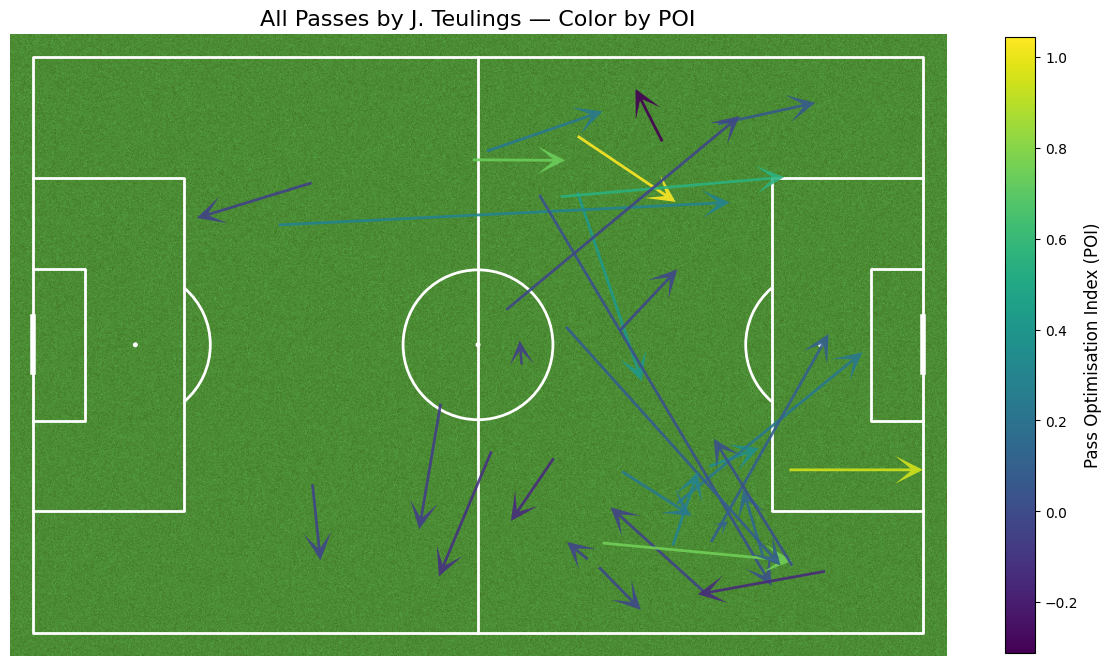

In [22]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import matplotlib.cm as cm

# STEP 1: Select the player
target_player = 'J. Teulings'
player_data = passes[passes['playerName'] == target_player].copy()

# STEP 2: Compute POI for each pass
poi_passes = []

for idx, row in player_data.iterrows():
    x, y = row['x'], row['y']
    end_x, end_y = row['end_x'], row['end_y']

    ev_actual = calculate_xpass_advanced(x, y, end_x, end_y) * calculate_threat_gain(x, y, end_x, end_y)
    top_opts = get_top_pass_options_from(x, y, n_options=3)
    ev_best = max(opt[2] for opt in top_opts)

    poi = ev_actual / ev_best if ev_best > 0 else 0

    poi_passes.append({
        'start_x': x,
        'start_y': y,
        'end_x': end_x,
        'end_y': end_y,
        'poi': poi
    })

poi_df = pd.DataFrame(poi_passes)

# STEP 3: Normalize POI for color map
norm = plt.Normalize(poi_df['poi'].min(), poi_df['poi'].max())
cmap = cm.get_cmap('viridis')

# STEP 4: Plot on pitch
pitch = Pitch(pitch_type='opta', pitch_color='grass', line_color='white')
fig, ax = pitch.draw(figsize=(12, 8))

for _, row in poi_df.iterrows():
    color = cmap(norm(row['poi']))
    pitch.arrows(row['start_x'], row['start_y'], row['end_x'], row['end_y'],
                 color=color, ax=ax, width=2, headwidth=10, headlength=10, alpha=0.9)

# STEP 5: Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Pass Optimisation Index (POI)', fontsize=12)

plt.title(f"All Passes by {target_player} — Color by POI", fontsize=16)
plt.show()


In [25]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

# STEP 3: Load match CSV
file_path = '/content/drive/MyDrive/Outswinger FC/Eredivisie Women 2024-2025/Utrecht 1-0 Feyenoord.csv'
df = pd.read_csv(file_path)

# STEP 4: Filter passes
passes = df[df['typeId'] == 1].copy()

# STEP 5: Extract end_x and end_y from qualifiers
def extract_qualifier_value(row, target_id):
    for i in range(20):
        qid_col = f'qualifier/{i}/qualifierId'
        val_col = f'qualifier/{i}/value'
        if qid_col in row and val_col in row:
            if pd.notnull(row[qid_col]) and int(row[qid_col]) == target_id:
                try:
                    return float(row[val_col])
                except:
                    return np.nan
    return np.nan

passes['end_x'] = passes.apply(lambda row: extract_qualifier_value(row, 140), axis=1)
passes['end_y'] = passes.apply(lambda row: extract_qualifier_value(row, 141), axis=1)
passes.dropna(subset=['x', 'y', 'end_x', 'end_y', 'playerName', 'contestantId'], inplace=True)

# STEP 6: Define xPass model
def calculate_xpass_advanced(start_x, start_y, end_x, end_y):
    dx = end_x - start_x
    dy = end_y - start_y
    distance = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx)
    b0, b1, b2, b3, b4, b5 = 3.0, -0.07, -1.2, -0.015, -0.015, -0.01
    z = b0 + b1 * distance + b2 * abs(angle) + b3 * abs(52.5 - end_x) + b4 * abs(34 - end_y) + b5 * (105 - start_x)
    return 1 / (1 + np.exp(-z))

# STEP 7: Threat gain
goal_x, goal_y = 105, 34
def calculate_threat_gain(start_x, start_y, end_x, end_y):
    start_dist = np.sqrt((goal_x - start_x)**2 + (goal_y - start_y)**2)
    end_dist = np.sqrt((goal_x - end_x)**2 + (goal_y - end_y)**2)
    return start_dist - end_dist

# STEP 8: POI model function
def get_pass_POI(x, y, end_x, end_y, step=5, max_distance=50):
    xpass_actual = calculate_xpass_advanced(x, y, end_x, end_y)
    threat_actual = calculate_threat_gain(x, y, end_x, end_y)
    ev_actual = xpass_actual * threat_actual

    best_ev = 0
    for tx in np.arange(5, 105, step):
        for ty in np.arange(5, 68, step):
            dist = np.sqrt((x - tx)**2 + (y - ty)**2)
            if dist < 1 or dist > max_distance:
                continue
            xpass = calculate_xpass_advanced(x, y, tx, ty)
            threat = calculate_threat_gain(x, y, tx, ty)
            ev = xpass * threat
            if ev > best_ev:
                best_ev = ev

    poi = ev_actual / best_ev if best_ev > 0 else 0
    return {
        'xPass': xpass_actual,
        'threat_gain': threat_actual,
        'EV_actual': ev_actual,
        'EV_best': best_ev,
        'POI': poi
    }

# STEP 9: Aggregate by player with POI breakdowns
player_results = []
players = passes['playerName'].dropna().unique()

for player in tqdm(players):
    player_data = passes[passes['playerName'] == player].copy()
    contestant_id = player_data['contestantId'].iloc[0]

    total_ev = 0
    poi_sum = 0
    poi_count = 0

    types = {'short': [], 'long': [], 'through': []}
    directions = {'forward': [], 'backward': [], 'lateral': []}
    zones = {'final_third': [], 'middle_third': [], 'wide': []}

    for _, row in player_data.iterrows():
        x, y = row['x'], row['y']
        end_x, end_y = row['end_x'], row['end_y']
        dx, dy = end_x - x, end_y - y
        dist = np.sqrt(dx**2 + dy**2)
        angle = abs(np.degrees(np.arctan2(dy, dx)))

        poi_info = get_pass_POI(x, y, end_x, end_y)
        poi = poi_info['POI']

        # Pass type classification
        if dist < 15:
            types['short'].append(poi)
        elif dist > 30:
            types['long'].append(poi)
        elif angle < 25 and dx > 0:
            types['through'].append(poi)

        # Direction classification
        if dx > 1:
            directions['forward'].append(poi)
        elif dx < -1:
            directions['backward'].append(poi)
        else:
            directions['lateral'].append(poi)

        # Zone classification
        if x >= 70:
            zones['final_third'].append(poi)
        elif 35 <= x < 70:
            zones['middle_third'].append(poi)
        if y < 20 or y > 48:
            zones['wide'].append(poi)

        total_ev += poi_info['EV_actual']
        poi_sum += poi
        poi_count += 1

    row = {
        'playerName': player,
        'contestantId': contestant_id,
        'pass_count': poi_count,
        'expected_value_total': round(total_ev, 3),
        'POI': round(poi_sum / poi_count if poi_count > 0 else 0, 3)
    }

    # Add POI per type
    for key, vals in types.items():
        row[f'POI_{key}'] = round(np.mean(vals), 3) if vals else None

    # Add POI per direction
    for key, vals in directions.items():
        row[f'POI_{key}'] = round(np.mean(vals), 3) if vals else None

    # Add POI per zone
    for key, vals in zones.items():
        row[f'POI_{key}'] = round(np.mean(vals), 3) if vals else None

    player_results.append(row)

# STEP 10: Save to Excel
poi_df = pd.DataFrame(player_results)
output_path = '/content/drive/MyDrive/Outswinger FC/Pass_Optimisation_Index_Detailed.xlsx'
poi_df.to_excel(output_path, index=False)

print(f"✅ Detailed POI breakdown saved to:\n{output_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 29/29 [00:04<00:00,  6.98it/s]

✅ Detailed POI breakdown saved to:
/content/drive/MyDrive/Outswinger FC/Pass_Optimisation_Index_Detailed.xlsx


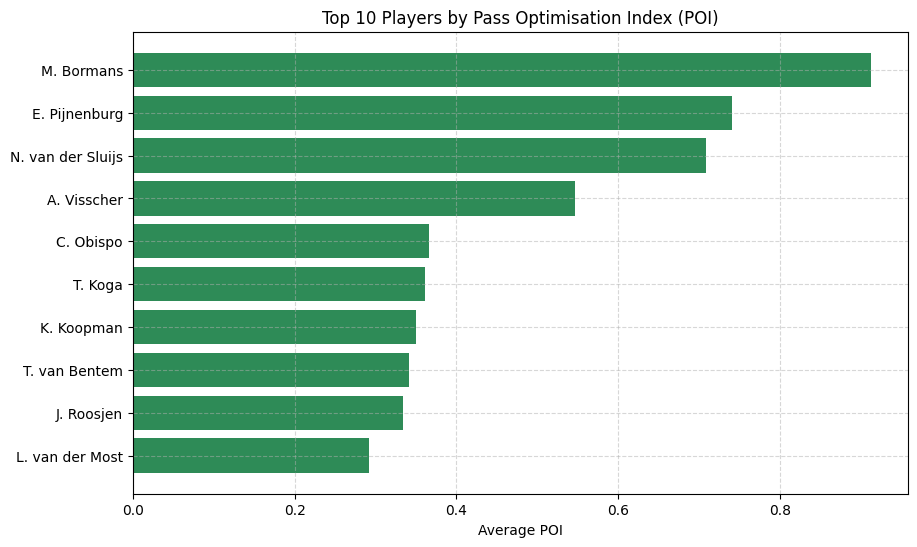

In [26]:
import matplotlib.pyplot as plt

top_players = poi_df.sort_values('POI', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_players['playerName'], top_players['POI'], color='seagreen')
plt.xlabel('Average POI')
plt.title('Top 10 Players by Pass Optimisation Index (POI)')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


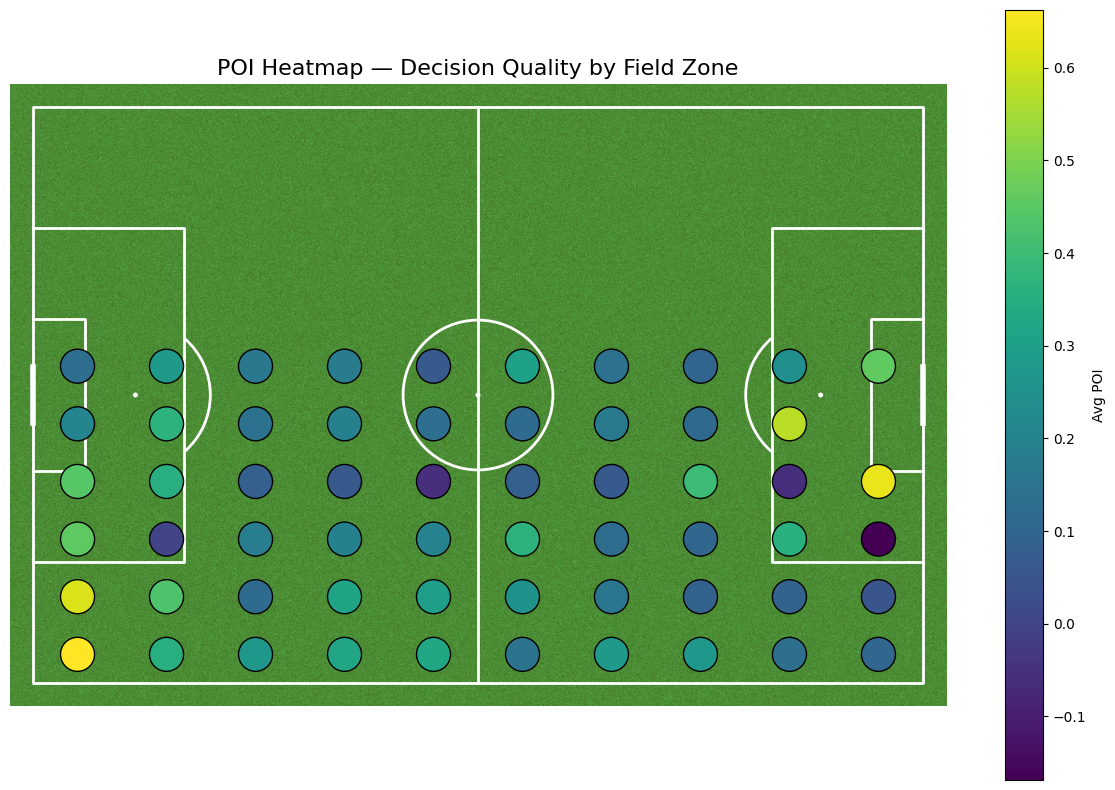

In [28]:
from mplsoccer import Pitch
import seaborn as sns

# Create pitch grid
pitch = Pitch(pitch_type='opta', pitch_color='grass', line_color='white')
fig, ax = pitch.draw(figsize=(12, 8))

# Bin passes by location and POI
passes['x_bin'] = pd.cut(passes['x'], bins=np.arange(0, 110, 10), labels=False)
passes['y_bin'] = pd.cut(passes['y'], bins=np.arange(0, 70, 10), labels=False)

heat = passes.copy()
heat['POI'] = heat.apply(lambda row: get_pass_POI(row['x'], row['y'], row['end_x'], row['end_y'])['POI'], axis=1)
zone_poi = heat.groupby(['x_bin', 'y_bin'])['POI'].mean().reset_index()

# Map bin center coords
zone_poi['x'] = zone_poi['x_bin'] * 10 + 5
zone_poi['y'] = zone_poi['y_bin'] * 10 + 5

# Plot
sc = pitch.scatter(zone_poi['x'], zone_poi['y'], c=zone_poi['POI'], s=600,
                   ax=ax, cmap='viridis', edgecolors='black')
plt.colorbar(sc, ax=ax, label='Avg POI')
plt.title('POI Heatmap — Decision Quality by Field Zone', fontsize=16)
plt.show()


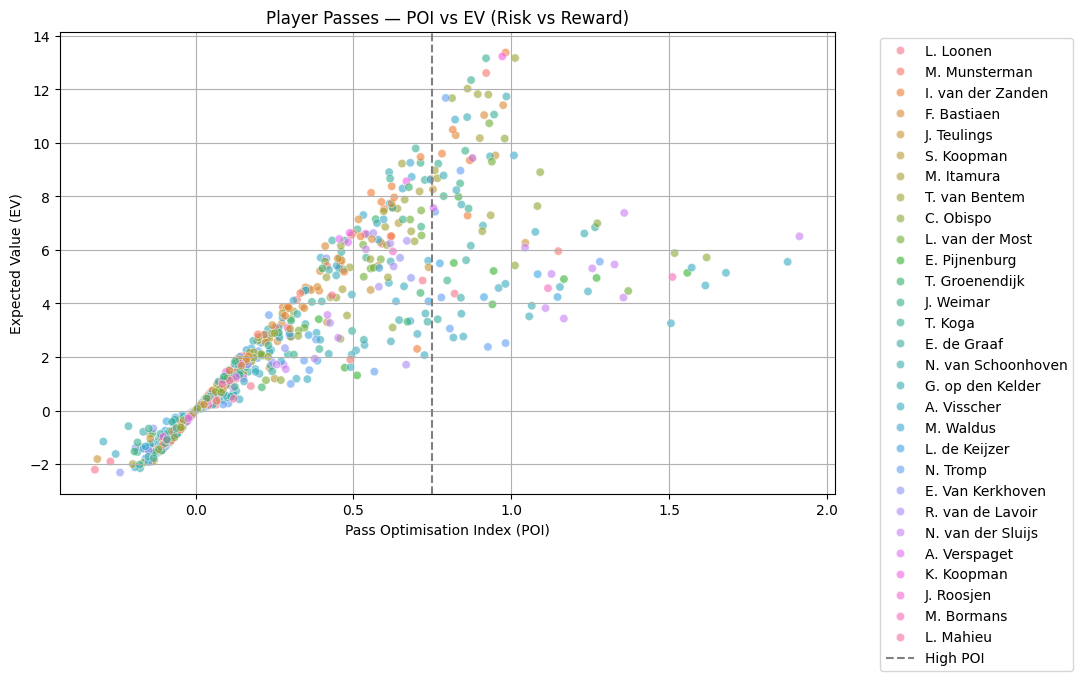

In [29]:
# Create DataFrame with EV + POI per pass
poi_pass_data = []

for _, row in passes.iterrows():
    poi_data = get_pass_POI(row['x'], row['y'], row['end_x'], row['end_y'])
    poi_pass_data.append({
        'playerName': row['playerName'],
        'EV': poi_data['EV_actual'],
        'POI': poi_data['POI']
    })

poi_ev_df = pd.DataFrame(poi_pass_data)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=poi_ev_df, x='POI', y='EV', hue='playerName', alpha=0.6)
plt.axvline(0.75, linestyle='--', color='gray', label='High POI')
plt.xlabel('Pass Optimisation Index (POI)')
plt.ylabel('Expected Value (EV)')
plt.title('Player Passes — POI vs EV (Risk vs Reward)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


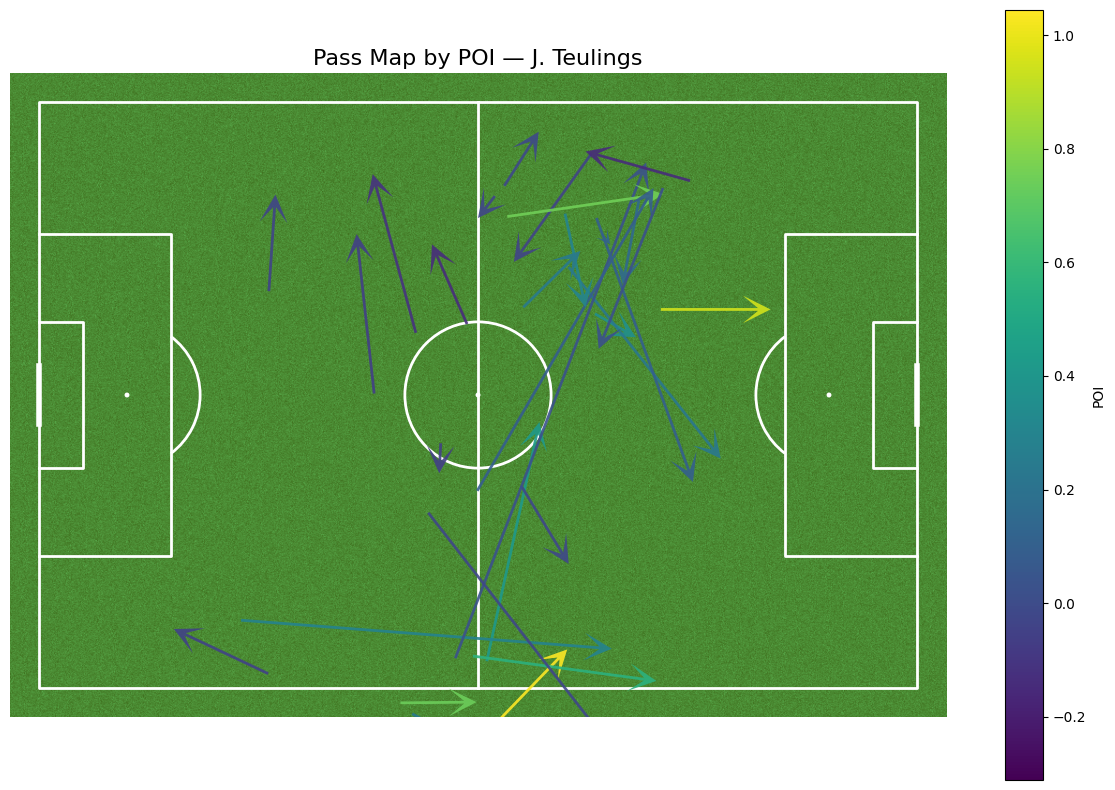

In [30]:
target_player = 'J. Teulings'
player_passes = passes[passes['playerName'] == target_player].copy()

# Add POI per pass
player_passes['POI'] = player_passes.apply(
    lambda row: get_pass_POI(row['x'], row['y'], row['end_x'], row['end_y'])['POI'], axis=1)

# Plot
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
fig, ax = pitch.draw(figsize=(12, 8))

norm = plt.Normalize(player_passes['POI'].min(), player_passes['POI'].max())
cmap = plt.cm.viridis

for _, row in player_passes.iterrows():
    color = cmap(norm(row['POI']))
    pitch.arrows(row['x'], row['y'], row['end_x'], row['end_y'],
                 ax=ax, color=color, width=2, headwidth=10, headlength=10, alpha=0.9)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('POI')
plt.title(f'Pass Map by POI — {target_player}', fontsize=16)
plt.show()


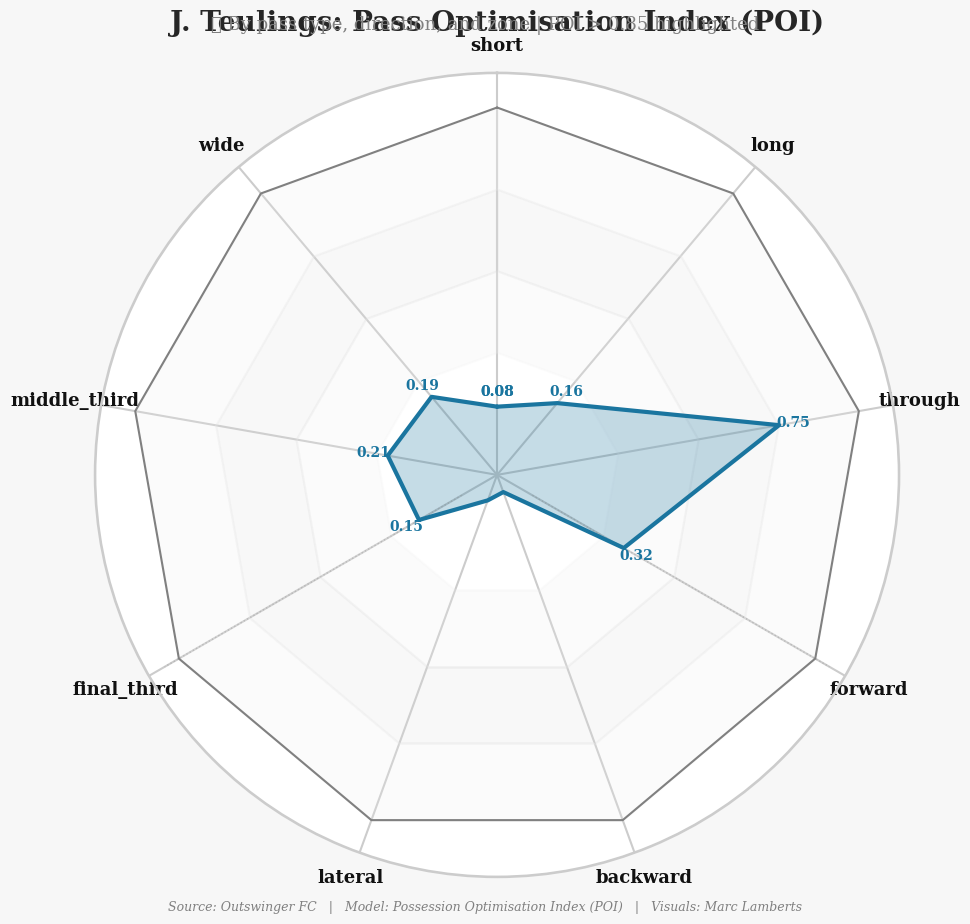

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Load data for one player ---
p = poi_df[poi_df['playerName'] == 'J. Teulings'].iloc[0]

labels = ['short', 'long', 'through', 'forward', 'backward', 'lateral',
          'final_third', 'middle_third', 'wide']
values = [p.get(f'POI_{l}', 0) if pd.notnull(p.get(f'POI_{l}', 0)) else 0 for l in labels]
values += values[:1]

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# --- Figure Setup ---
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
fig.patch.set_facecolor('#F7F7F7')
ax.set_facecolor('white')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# --- Grid + ring shading ---
grid_levels = [0.25, 0.5, 0.75, 1.0]
for i in range(1, len(grid_levels)):
    ax.fill_between(
        angles,
        [grid_levels[i-1]] * len(angles),
        [grid_levels[i]] * len(angles),
        color='#DDDDDD' if i % 2 == 0 else '#EEEEEE',
        alpha=0.2
    )

# Grid labels
ax.set_rgrids(grid_levels, angle=90, fontsize=10, color='gray', ha='center')
ax.set_rticks([])
ax.plot(angles, [1]*len(angles), color='gray', linewidth=1.5)  # outer ring

# Axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=13, fontweight='semibold', color='#111111')

# --- Plotting Data ---
ax.plot(angles, values, color='#1A759F', linewidth=3, zorder=3)
ax.fill(angles, values, color='#1A759F', alpha=0.25, zorder=2)

# Annotated POI values on tips
for angle, value in zip(angles, values):
    if value > 0.05:
        align = 'center'
        ax.text(angle, value + 0.045, f"{value:.2f}",
                ha=align, va='center', fontsize=10,
                fontweight='bold', color='#1A759F')

# --- Highlight best segments (POI > 0.85) ---
for i, val in enumerate(values[:-1]):
    if val >= 0.85:
        ax.plot([angles[i], angles[i]], [0, val],
                color='#52B788', linewidth=3, linestyle='--', alpha=0.6, zorder=1)

# --- Add thin group rings or breaks (optional aesthetic cue) ---
for i in [3, 6]:  # after 3 and 6 dimensions (type/direction/zone)
    ax.plot([angles[i], angles[i]], [0, 1.05], color='gray', linewidth=1, linestyle=':', alpha=0.3)

# --- Title and subtitles ---
plt.title(f"{p['playerName']}: Pass Optimisation Index (POI)", fontsize=20, fontweight='bold', pad=30)
plt.suptitle("🧠 By pass type, direction, and zone | POI > 0.85 highlighted", fontsize=13, y=0.91, color='gray')

# --- Source note ---
plt.figtext(0.5, 0.015,
            "Source: Outswinger FC   |   Model: Possession Optimisation Index (POI)   |   Visuals: Marc Lamberts",
            ha='center', fontsize=9, style='italic', color='gray')

plt.tight_layout()
plt.show()


<ipython-input-32-4560cd8871df>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=type_df, x='type', y='POI', palette='Set2')


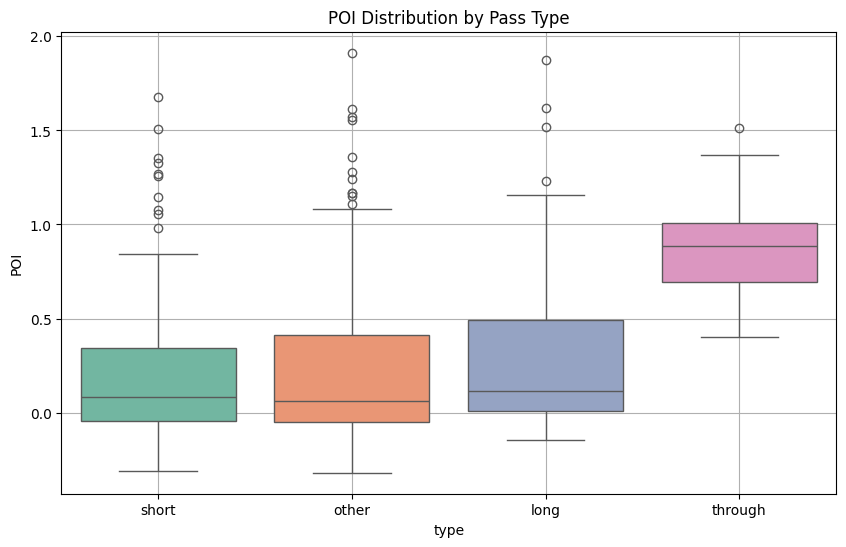

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create full POI list for all passes with label
poi_type_data = []

for _, row in passes.iterrows():
    x, y, ex, ey = row['x'], row['y'], row['end_x'], row['end_y']
    dx = ex - x
    dist = np.sqrt(dx**2 + (ey - y)**2)
    angle = abs(np.degrees(np.arctan2(ey - y, dx)))
    poi = get_pass_POI(x, y, ex, ey)['POI']

    if dist < 15:
        label = 'short'
    elif dist > 30:
        label = 'long'
    elif angle < 25 and dx > 0:
        label = 'through'
    else:
        label = 'other'

    poi_type_data.append({'POI': poi, 'type': label})

type_df = pd.DataFrame(poi_type_data)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=type_df, x='type', y='POI', palette='Set2')
plt.title('POI Distribution by Pass Type')
plt.grid(True)
plt.show()


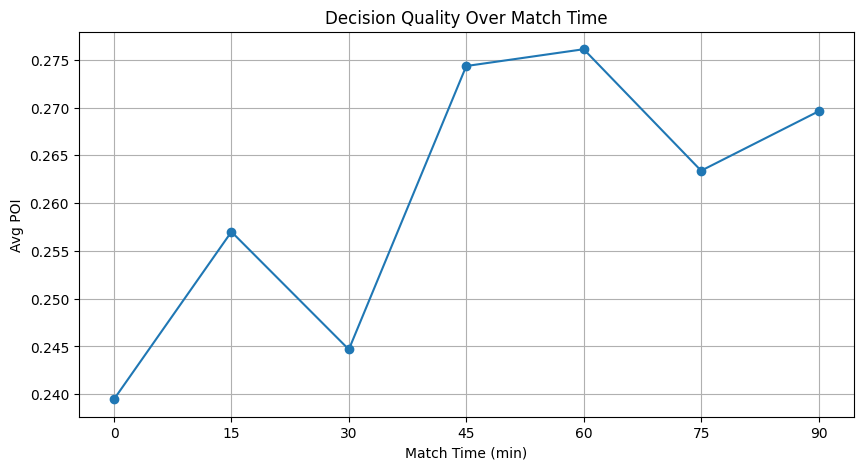

In [34]:
passes['minute'] = passes['timeMin']
passes['time_bucket'] = (passes['minute'] // 15) * 15

bucket_df = passes.copy()
bucket_df['POI'] = bucket_df.apply(lambda r: get_pass_POI(r['x'], r['y'], r['end_x'], r['end_y'])['POI'], axis=1)
time_poi = bucket_df.groupby('time_bucket')['POI'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(time_poi['time_bucket'], time_poi['POI'], marker='o')
plt.xticks(time_poi['time_bucket'])
plt.xlabel('Match Time (min)')
plt.ylabel('Avg POI')
plt.title('Decision Quality Over Match Time')
plt.grid(True)
plt.show()


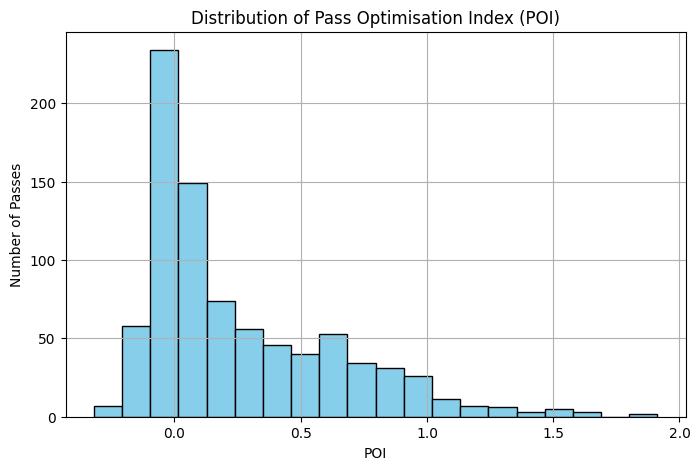

In [35]:
all_pois = passes.apply(lambda r: get_pass_POI(r['x'], r['y'], r['end_x'], r['end_y'])['POI'], axis=1)

plt.figure(figsize=(8, 5))
plt.hist(all_pois, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('POI')
plt.ylabel('Number of Passes')
plt.title('Distribution of Pass Optimisation Index (POI)')
plt.grid(True)
plt.show()


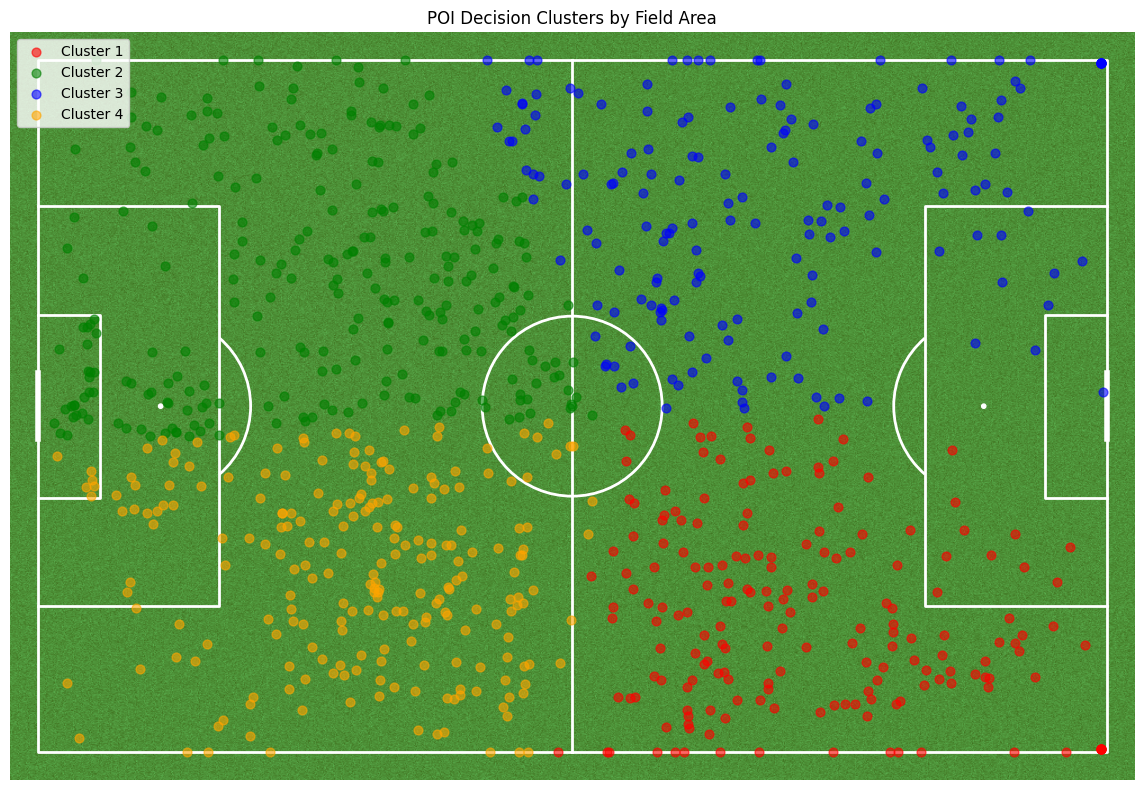

In [37]:
from sklearn.cluster import KMeans

# Add POI to passes
poi_data = passes.copy()
poi_data['POI'] = poi_data.apply(lambda r: get_pass_POI(r['x'], r['y'], r['end_x'], r['end_y'])['POI'], axis=1)

# Clustering based on start location and POI
kmeans = KMeans(n_clusters=4, random_state=42)
poi_data['cluster'] = kmeans.fit_predict(poi_data[['x', 'y', 'POI']])

# Visualize
pitch = Pitch(pitch_type='opta', pitch_color='grass', line_color='white')
fig, ax = pitch.draw(figsize=(12, 8))

colors = ['red', 'green', 'blue', 'orange']
for i in range(4):
    cluster_points = poi_data[poi_data['cluster'] == i]
    pitch.scatter(cluster_points['x'], cluster_points['y'], ax=ax, alpha=0.6, s=40, label=f'Cluster {i+1}', color=colors[i])

plt.title('POI Decision Clusters by Field Area')
plt.legend()
plt.show()


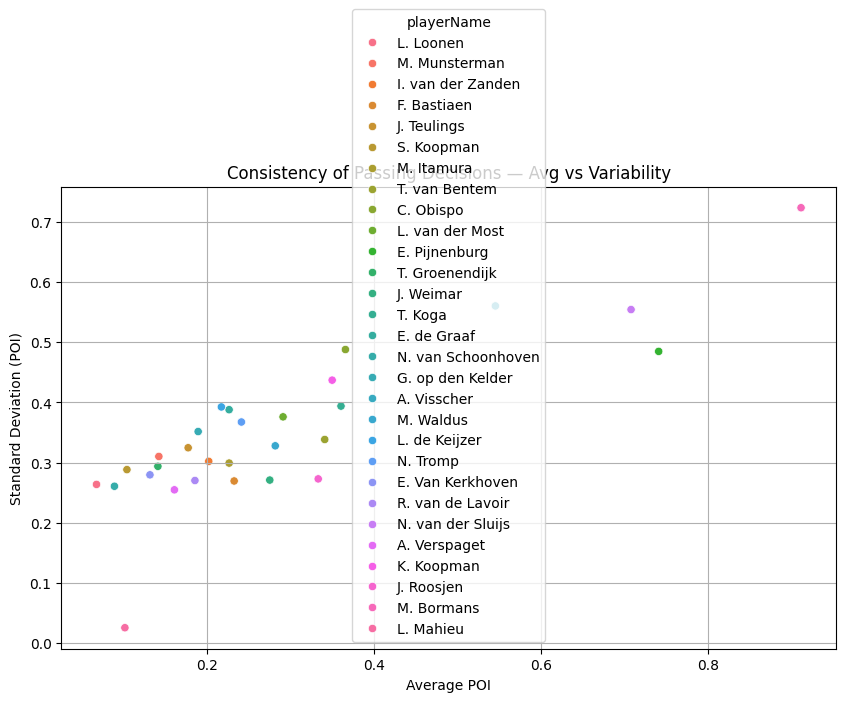

In [38]:
poi_std_data = []

for player in passes['playerName'].dropna().unique():
    pl = passes[passes['playerName'] == player]
    pois = pl.apply(lambda r: get_pass_POI(r['x'], r['y'], r['end_x'], r['end_y'])['POI'], axis=1)
    poi_std_data.append({'playerName': player, 'POI_std': pois.std(), 'POI_mean': pois.mean()})

poi_std_df = pd.DataFrame(poi_std_data)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=poi_std_df, x='POI_mean', y='POI_std', hue='playerName')
plt.xlabel('Average POI')
plt.ylabel('Standard Deviation (POI)')
plt.title('Consistency of Passing Decisions — Avg vs Variability')
plt.grid(True)
plt.show()


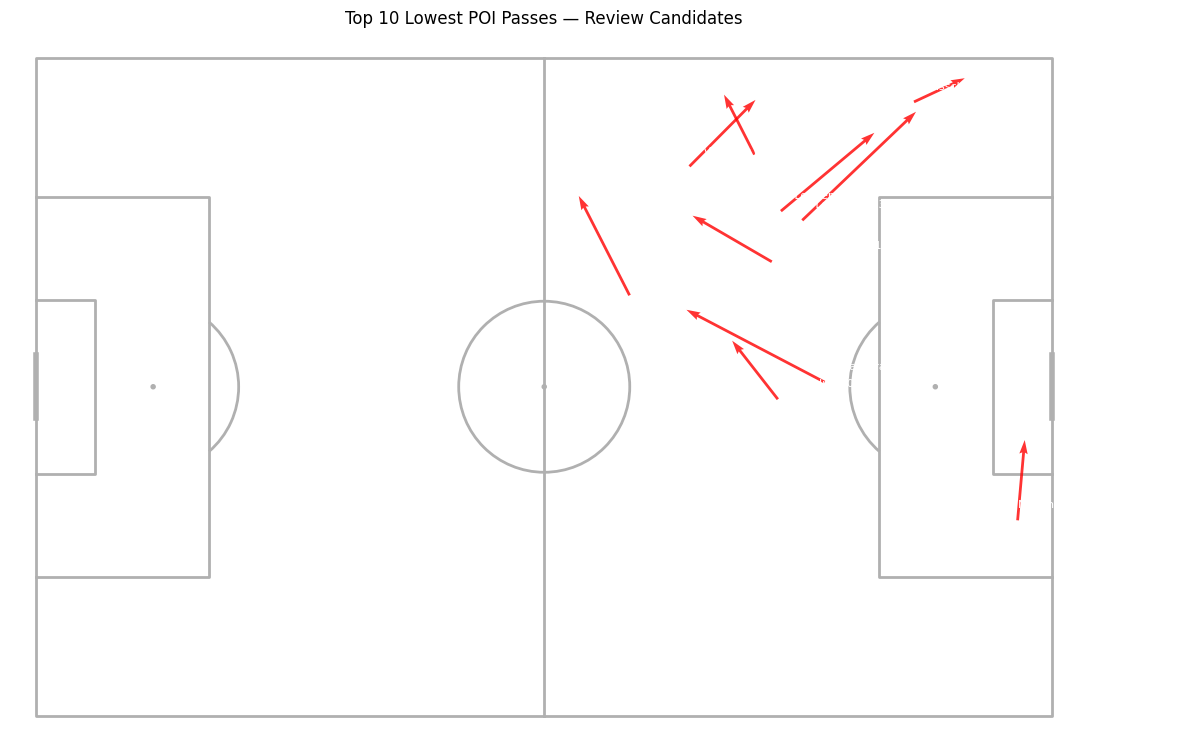

In [40]:
coaching_passes = []

for _, r in passes.iterrows():
    poi_info = get_pass_POI(r['x'], r['y'], r['end_x'], r['end_y'])
    coaching_passes.append({
        'player': r['playerName'],
        'x': r['x'], 'y': r['y'],
        'end_x': r['end_x'], 'end_y': r['end_y'],
        'POI': poi_info['POI']
    })

low_poi_df = pd.DataFrame(coaching_passes).sort_values('POI').head(10)

pitch = Pitch(pitch_type='opta')
fig, ax = pitch.draw(figsize=(12, 8))

for _, row in low_poi_df.iterrows():
    pitch.arrows(row['x'], row['y'], row['end_x'], row['end_y'], ax=ax, color='red', width=2, alpha=0.8)
    ax.text(row['x'], row['y'] + 2, f"{row['player']} ({row['POI']:.2f})", fontsize=8, color='white')

plt.title("Top 10 Lowest POI Passes — Review Candidates")
plt.show()


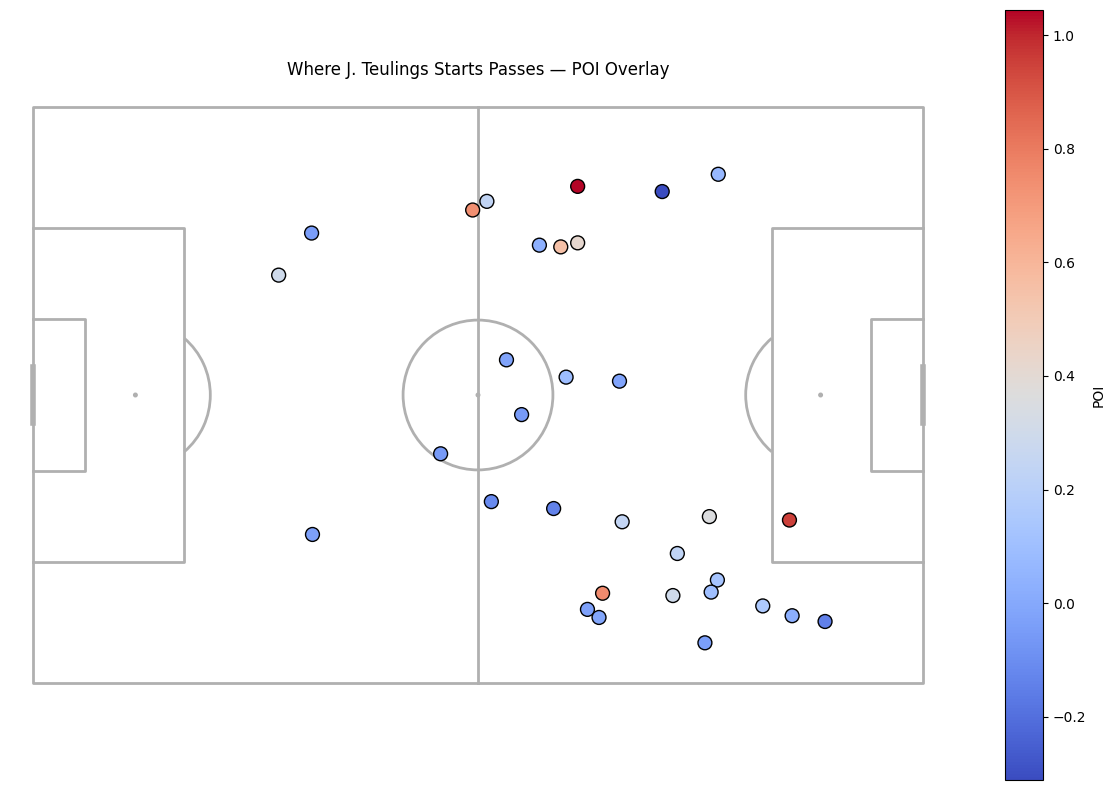

In [42]:
target_player = 'J. Teulings'
player_data = passes[passes['playerName'] == target_player].copy()
player_data['POI'] = player_data.apply(lambda r: get_pass_POI(r['x'], r['y'], r['end_x'], r['end_y'])['POI'], axis=1)

pitch = Pitch(pitch_type='opta')
fig, ax = pitch.draw(figsize=(12, 8))

sc = pitch.scatter(player_data['x'], player_data['y'], c=player_data['POI'],
                   ax=ax, s=100, cmap='coolwarm', edgecolors='black')
plt.colorbar(sc, ax=ax, label='POI')
plt.title(f"Where {target_player} Starts Passes — POI Overlay")
plt.show()


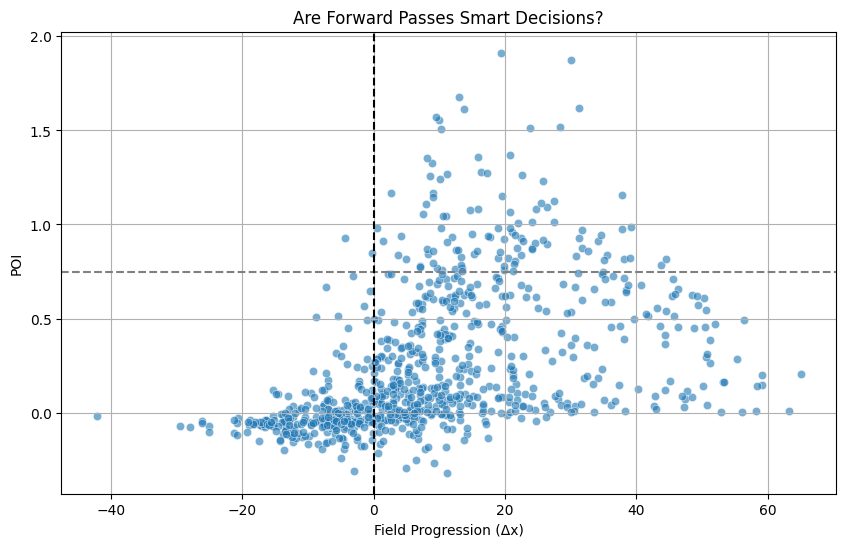

In [43]:
funnel_data = []

for _, row in passes.iterrows():
    dx = row['end_x'] - row['x']
    poi = get_pass_POI(row['x'], row['y'], row['end_x'], row['end_y'])['POI']
    funnel_data.append({'progress': dx, 'POI': poi})

funnel_df = pd.DataFrame(funnel_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=funnel_df, x='progress', y='POI', alpha=0.6)
plt.axhline(0.75, linestyle='--', color='gray')
plt.axvline(0, linestyle='--', color='black')
plt.xlabel('Field Progression (Δx)')
plt.ylabel('POI')
plt.title('Are Forward Passes Smart Decisions?')
plt.grid(True)
plt.show()


<ipython-input-44-01d4d5ac6161>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




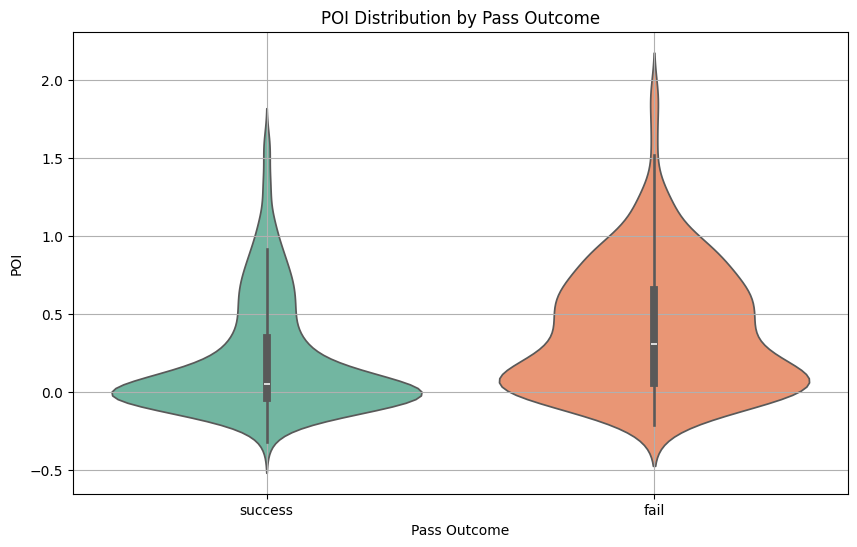

In [44]:
if 'outcome' in passes.columns:
    outcome_map = {1: 'success', 0: 'fail'}
    passes['outcome_label'] = passes['outcome'].map(outcome_map)
    passes['POI'] = passes.apply(lambda r: get_pass_POI(r['x'], r['y'], r['end_x'], r['end_y'])['POI'], axis=1)

    plt.figure(figsize=(10, 6))
    sns.violinplot(data=passes, x='outcome_label', y='POI', palette='Set2')
    plt.title('POI Distribution by Pass Outcome')
    plt.ylabel('POI')
    plt.xlabel('Pass Outcome')
    plt.grid(True)
    plt.show()


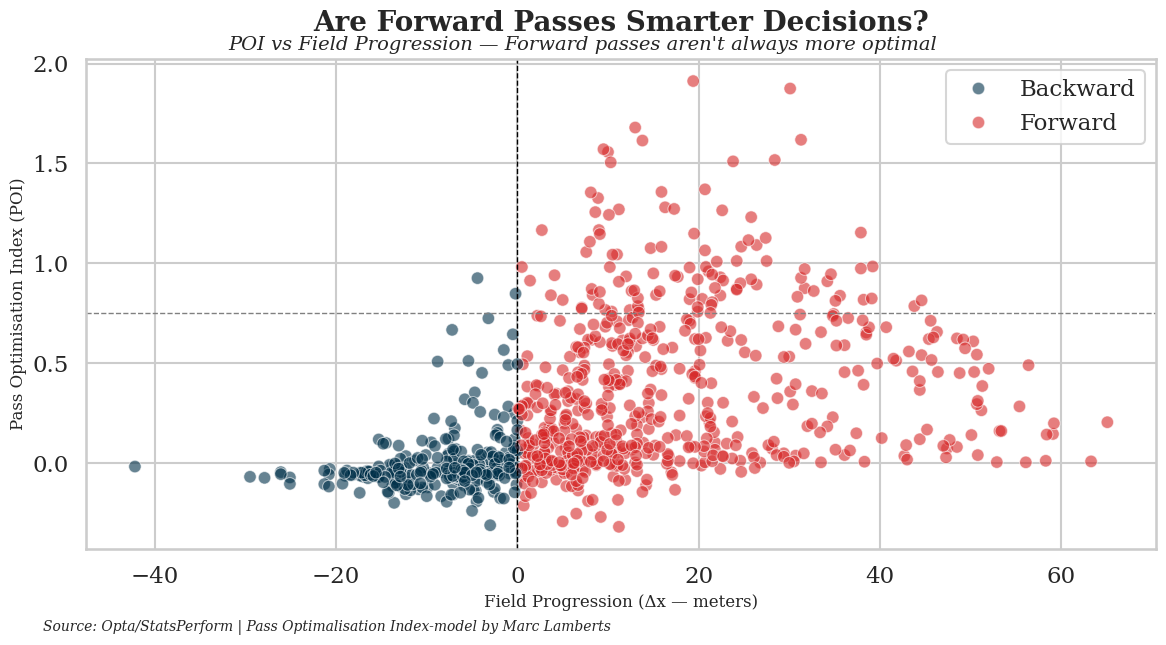

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Create the data
funnel_data = []

for _, row in passes.iterrows():
    dx = row['end_x'] - row['x']
    poi = get_pass_POI(row['x'], row['y'], row['end_x'], row['end_y'])['POI']
    funnel_data.append({'progress': dx, 'POI': poi})

funnel_df = pd.DataFrame(funnel_data)
funnel_df['direction'] = funnel_df['progress'].apply(lambda x: 'Forward' if x > 0 else 'Backward')

# Apply The Economist-style tweaks
sns.set_theme(style="whitegrid", font="serif", context="talk")

plt.figure(figsize=(12, 7))
palette = {"Forward": "#D62828", "Backward": "#003049"}
sns.scatterplot(data=funnel_df, x='progress', y='POI', hue='direction', alpha=0.6, palette=palette)

# Reference lines
plt.axhline(0.75, linestyle='--', color='gray', linewidth=1)
plt.axvline(0, linestyle='--', color='black', linewidth=1)

# Titles
plt.title("Are Forward Passes Smarter Decisions?", fontsize=20, weight='bold', pad=20)
plt.suptitle("POI vs Field Progression — Forward passes aren't always more optimal", fontsize=14, style='italic', y=0.86)

# Labels
plt.xlabel("Field Progression (Δx — meters)", fontsize=12)
plt.ylabel("Pass Optimisation Index (POI)", fontsize=12)
plt.legend(title='', loc='upper right')

# Source
plt.figtext(0.05, 0.01, "Source: Opta/StatsPerform | Pass Optimalisation Index-model by Marc Lamberts", fontsize=10, ha='left', style='italic')

plt.tight_layout()
plt.show()


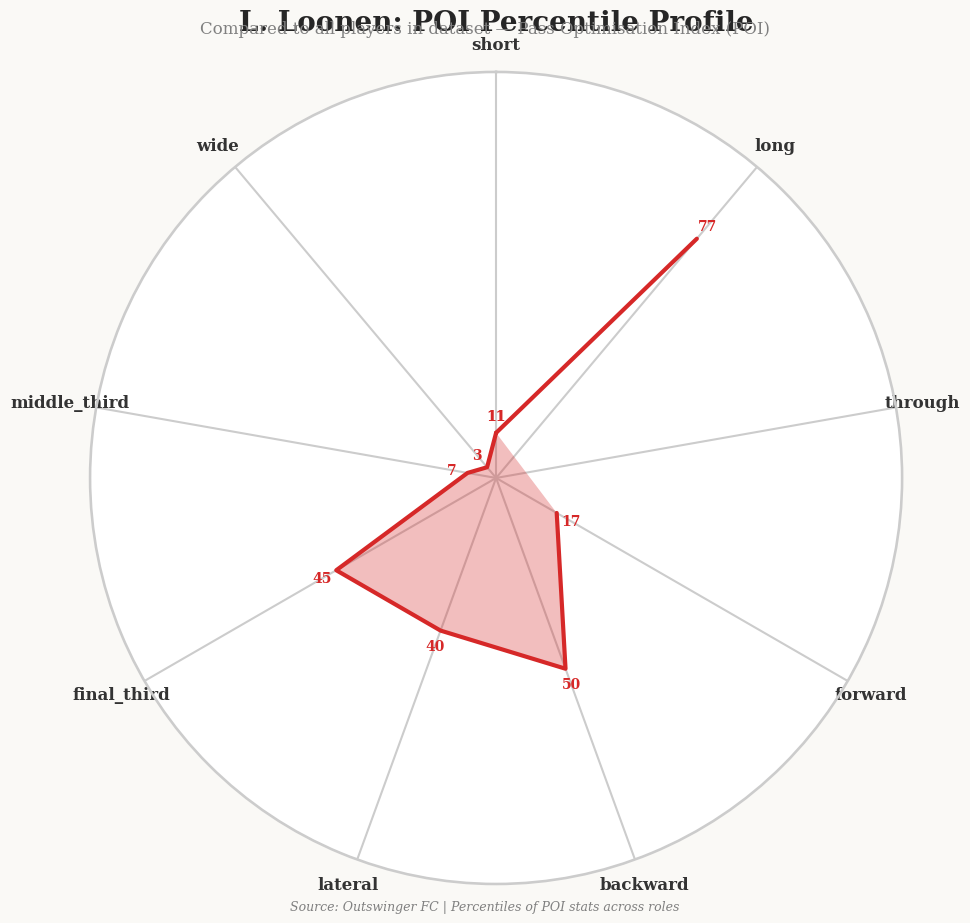

In [59]:
from scipy.stats import rankdata

# Set up the POI metrics
poi_metrics = ['short', 'long', 'through', 'forward', 'backward', 'lateral', 'final_third', 'middle_third', 'wide']

# Create percentile columns
for metric in poi_metrics:
    col = f'POI_{metric}'
    if col in poi_df.columns:
        valid = poi_df[col].dropna()
        percentile_col = f'{col}_pct'
        poi_df[percentile_col] = poi_df[col].rank(pct=True) * 100

import matplotlib.pyplot as plt
import numpy as np

# Select player
player_name = 'L. Loonen'
p = poi_df[poi_df['playerName'] == player_name].iloc[0]

# Extract percentile values
labels = poi_metrics
values = [p.get(f'POI_{m}_pct', 0) for m in labels]
values += values[:1]  # loop to start
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# --- Setup Pizza Figure ---
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
fig.patch.set_facecolor('#FAF9F6')
ax.set_facecolor('white')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Ring grid
ax.set_rgrids([25, 50, 75, 100], labels=['25', '50', '75', '100'], angle=90, fontsize=10, color='gray')
ax.set_ylim(0, 100)
ax.set_rticks([])

# Axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12, fontweight='semibold', color='#333')

# Data line
ax.plot(angles, values, color='#D62828', linewidth=3)
ax.fill(angles, values, color='#D62828', alpha=0.3)

# Value annotations
for angle, value in zip(angles, values):
    ax.text(angle, value + 4, f"{value:.0f}", ha='center', va='center',
            fontsize=10, fontweight='bold', color='#D62828')

# Titles
plt.title(f"{player_name}: POI Percentile Profile", fontsize=20, fontweight='bold', pad=30)
plt.suptitle("Compared to all players in dataset — Pass Optimisation Index (POI)", fontsize=12, y=0.91, color='gray')

# Source
plt.figtext(0.5, 0.02, "Source: Outswinger FC | Percentiles of POI stats across roles", ha='center',
            fontsize=9, style='italic', color='gray')

plt.tight_layout()
plt.show()
